# Contexte : parcours Data Scientist promotion 24FEV 2024 - DataScientest.com 
**Description du projet :**
<br>
Afin de faire le diagnostic des patients au Covid-19, l’analyse de radiographies pulmonaires est une possibilité à explorer pour détecter plus facilement les cas positifs. Si la classification par le biais du deep learning de telles données se révèle efficace pour détecter les cas positifs, alors cette méthode peut être utilisée dans les hôpitaux et cliniques quand on ne peut pas faire de test classique.<br>
**Mots clés:**
<br>
DL (Deep Learning), CNN (
Convolutional Neural Networ), Kagglek 
<brid

# I. Import dataset from Kaggle

In [1]:
# Command to opendatasets from Kaggle

import opendatasets as od


In [7]:
# download the database
#od.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database")

100%|██████████| 778M/778M [01:30<00:00, 8.99MB/s] 


# II. Data Exploration & Viz"

## 2.1 Lodaing packeges

In [2]:
# Import packages

from glob import glob # list all the files of a directory
import os 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# ignore warning messages
import warnings
warnings.filterwarnings("ignore")

## 2.2 Reading files


In [3]:
# print current directory
os.getcwd()  # equivalent to pwd

'C:\\Users\\chaou'

In [4]:
# Change current directory to work directory
os.chdir(r"C:/Users/chaou/covid19-radiography-database/")

In [5]:
# Listing the files in the directory
files = os.listdir(r"C:/Users/chaou/covid19-radiography-database/")
files

['cam.jpg',
 'class_images_size.png',
 'class_images_size.svg',
 'COVID',
 'COVID.metadata.xlsx',
 'df_images.csv',
 'df_masks.csv',
 'DST_project_radio_covid',
 'EfficientNetB4_base_model_hist.csv',
 'EfficientNet_models_benchmark.csv',
 'EfficientNet_models_benchmark_vf.csv',
 'Lung_Opacity',
 'Lung_Opacity.metadata.xlsx',
 'Normal',
 'Normal.metadata.xlsx',
 'ratio_surface_utile.png',
 'ratio_surface_utile.svg',
 'README.md.txt',
 'tb_logs',
 'Téléchargements',
 'Viral Pneumonia',
 'Viral Pneumonia.metadata.xlsx']

In [6]:
# Import data form the files as DataFrames 
covid_df = pd.read_excel('COVID.metadata.xlsx')
lung_opacity_df = pd.read_excel('Lung_Opacity.metadata.xlsx')
normal_df = pd.read_excel('Normal.metadata.xlsx')
viral_pneumonia_df = pd.read_excel('Viral Pneumonia.metadata.xlsx')

# concatenate the DataFrames to form one data set
data_frames = [covid_df, lung_opacity_df, normal_df, viral_pneumonia_df]
files_data = pd.concat(data_frames)
files_data.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


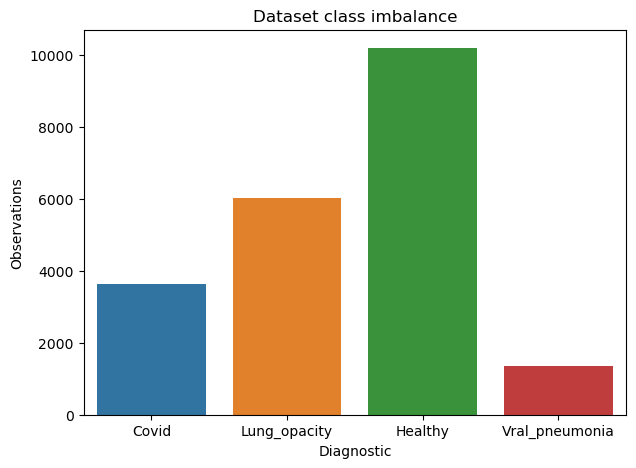

In [7]:
# Bar plot to see the data composition
file_counts = {'Diagnostic'   : ['Covid', 'Lung_opacity', 'Healthy', 'Vral_pneumonia'],
               'Observations' : [len(covid_df), len(lung_opacity_df), len(normal_df), len(viral_pneumonia_df)]}
file_counts_df = pd.DataFrame.from_dict(file_counts)

plt.figure(figsize=(7, 5))
sns.barplot(x='Diagnostic', y='Observations', data=file_counts_df)
plt.title("Dataset class imbalance")
plt.show();


## 2.3 Image visualization 

In [8]:
# Loading images from the directories
covid_images           = glob(r'C:\Users\chaou\covid19-radiography-database\COVID\images\*.png')
lung_opacity_images    = glob(r'C:\Users\chaou\covid19-radiography-database\Lung_Opacity\images\*.png')
normal_images          = glob(r'C:\Users\chaou\covid19-radiography-database\Normal\images\*.png')
viral_pneumonia_images = glob(r'C:\Users\chaou\covid19-radiography-database\Viral Pneumonia\images\*.png')

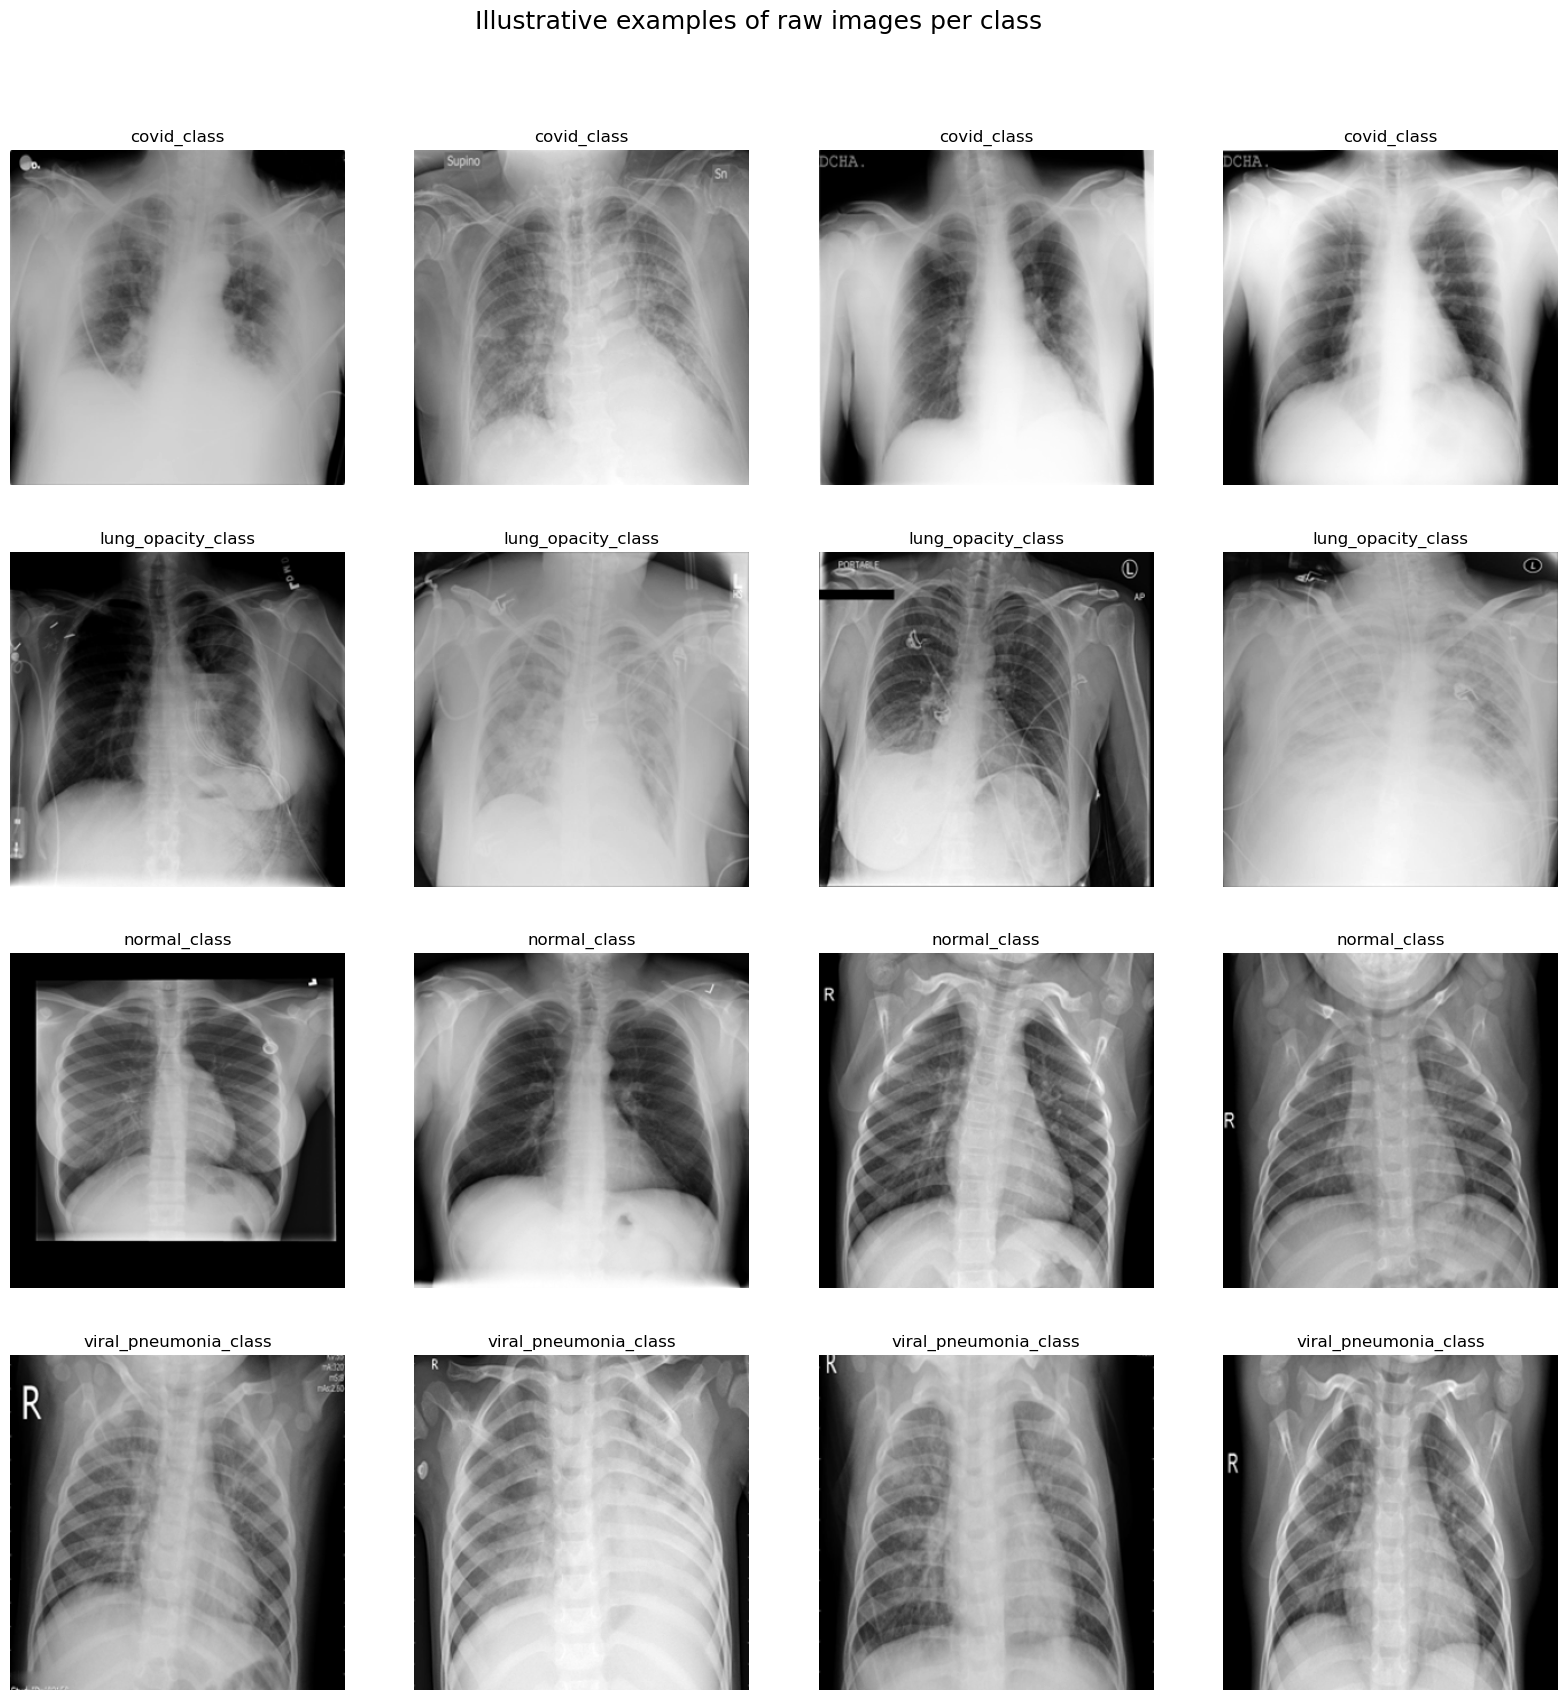

In [9]:
# Plotting Image from each class
images_path_dict={'covid_class': covid_images,
             'lung_opacity_class': lung_opacity_images,
             'normal_class': normal_images,
             'viral_pneumonia_class': viral_pneumonia_images}

n_rows = len(images_path_dict)
n_cols = 4  #  Number of images to show per class

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 20))
#plt.subplots_adjust(hspace=0.1)
fig.suptitle("Illustrative examples of raw images per class", fontsize=18, y=0.95)

for i, class_ in enumerate(images_path_dict.keys()):
    for j, img in enumerate(images_path_dict[class_][:n_cols]):
        #print(class_)
        #print(images_path_dict[class_][j])
        #print(i, j)
        img = plt.imread(images_path_dict[class_][j])
        
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_title(class_)
        ax[i,j].axis('off')
plt.show();


Class_COVID
|████████████████████████████████████████| 3616 in 4.4s (828.77/s) 
Class_Lung_Opacity
|████████████████████████████████████████| 6012 in 6.9s (868.72/s) 
Class_Normal
|████████████████████████████████████████| 10192 in 12.6s (810.43/s) 
Class_Viral_Pneumonia
|████████████████████████████████████████| 1345 in 1.7s (770.50/s) 


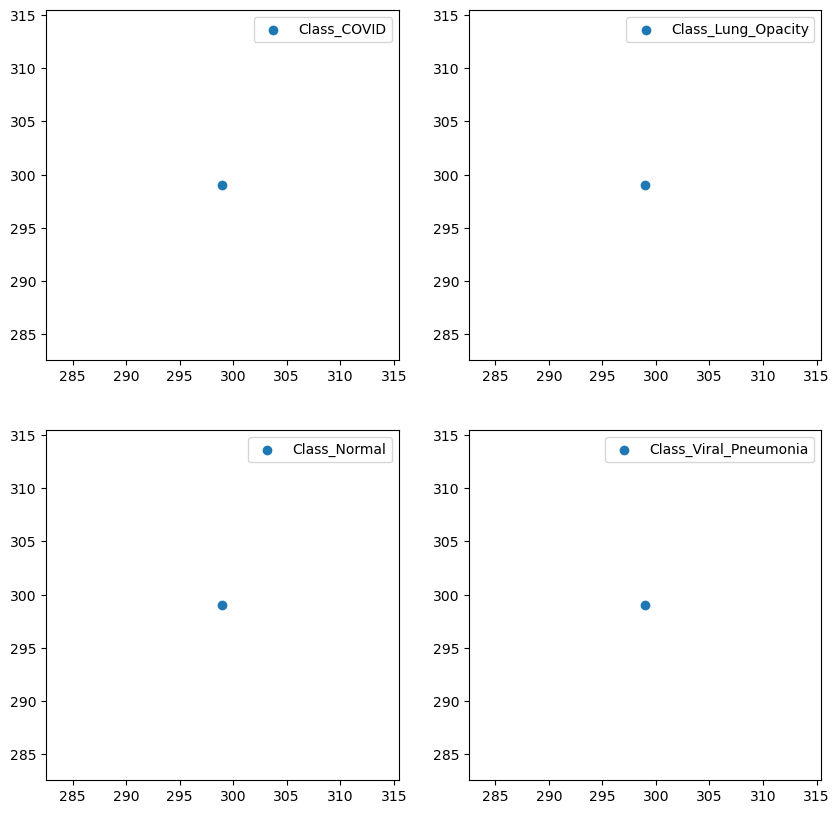

In [10]:
# Checking and Plotting images sizes 

from PIL import Image  # Python Imaging Library (PIL) is a library used when working with images
from alive_progress import alive_bar  # affichage d'une bar de chargement
import time

directories = {'Class_COVID': covid_images,
               'Class_Lung_Opacity': lung_opacity_images,
               'Class_Normal': normal_images,
               'Class_Viral_Pneumonia': viral_pneumonia_images}
j = 1

plt.figure(figsize=(10, 10))

# Selecting images with 3 channels
index_oversize_img = []
path_oversize_img = []

for class_label in directories.keys():
    print(class_label)
    with alive_bar() as bar: # show loading bar
        for index, img_path in enumerate(directories[class_label]):
            img = Image.open(img_path)
            arr = np.array(img)
            bar() # show loading bar
            
            if arr.ndim == 2:
                h, w = arr.shape  # get the images dims
            
            if arr.ndim == 3:
                h, w, d = arr.shape
                
            if arr.ndim > 2:
                index_oversize_img.append(index)
                index_oversize_img_arr = np.array(index_oversize_img)
                path_oversize_img.append(img_path)
                
                df_oversized_img = pd.DataFrame({'img_index' : index_oversize_img_arr, 
                                                 'img_path' : img_path})
 
    plt.subplot(2, 2, j)
    j = j +1
    plt.scatter(x=w, y=h, label=class_label)
    fig.suptitle("Taille d'iamges par classe", fontsize=18, y=0.95)
    plt.legend()
    plt.savefig('class_images_size.svg')
    plt.savefig('class_images_size.png')


The number of over sized images is: 140


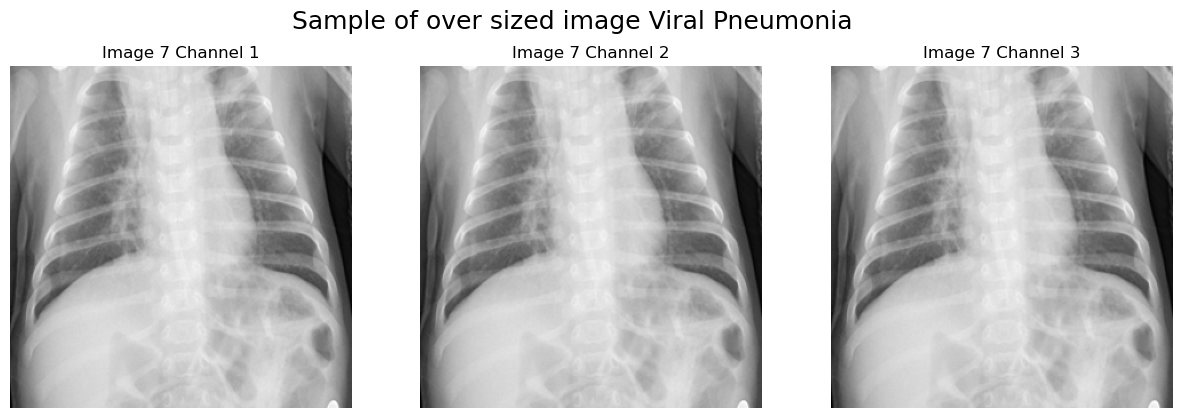

In [11]:
# Store images in a DataFrame

df_oversized_img

# Show one over sized image from Viral Pneumonia
img = plt.imread(df_oversized_img['img_path'][0])

fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.suptitle('Sample of over sized image Viral Pneumonia', fontsize=18, y=0.95)

for i in range(3):
    ax[i].imshow(img[:,:,i], cmap='gray')
    ax[i].set_title('Image' +' ' + str(df_oversized_img['img_index'][0]) + ' '+ 'Channel' +' '+ str(i+1))
    ax[i].axis('off')

    
print('The number of over sized images is:', len(df_oversized_img['img_index']))

# III. Data Pre-processing

In [12]:
# 1. Real meta data DF

directories = {'Class_COVID': covid_images,
               'Class_Lung_Opacity': lung_opacity_images,
               'Class_Normal': normal_images,
               'Class_Viral_Pneumonia': viral_pneumonia_images}
img_data = []
for class_label in directories.keys():
    for index, img_path in enumerate(directories[class_label]):
        img = Image.open(img_path)
        arr = np.array(img)
        # take the mean of the 3 channels 
        #if arr.ndim == 3:
        #    arr = np.mean(arr, axis=2) 
        img_size = arr.shape
        img_data.append([img_size, class_label, img_path])

img_metadata = pd.DataFrame(img_data, columns = ['image_size', 'class', 'image_path'])   

In [13]:
# Show the new dataframe
img_metadata.head()

,image_size,class,image_path
0,"(299, 299)",Class_COVID,C:\Users\chaou\covid19-radiography-database\CO...
1,"(299, 299)",Class_COVID,C:\Users\chaou\covid19-radiography-database\CO...
2,"(299, 299)",Class_COVID,C:\Users\chaou\covid19-radiography-database\CO...
3,"(299, 299)",Class_COVID,C:\Users\chaou\covid19-radiography-database\CO...
4,"(299, 299)",Class_COVID,C:\Users\chaou\covid19-radiography-database\CO...


### 3.1 Mask Processing 


In [14]:
# Loading masks from the directories
covid_masks           = glob(r'C:\Users\chaou\covid19-radiography-database\COVID\masks\*.png')
lung_opacity_masks    = glob(r'C:\Users\chaou\covid19-radiography-database\Lung_Opacity\masks\*.png')
normal_masks          = glob(r'C:\Users\chaou\covid19-radiography-database\Normal\masks\*.png')
viral_pneumonia_masks = glob(r'C:\Users\chaou\covid19-radiography-database\Viral Pneumonia\masks\*.png')

# mask for each class
mask_directories = {'COVID_masks': covid_masks,
                    'Lung_Opacity_masks': lung_opacity_masks,
                    'Normal_masks': normal_masks,
                    'Viral_Pneumonia_masks': viral_pneumonia_masks}

# Mask meta data
mask_data = []

for mask_class in mask_directories.keys():
    print(mask_class)
    for index, mask_path in enumerate(mask_directories[mask_class]):
        img_msk = Image.open(mask_path)
        arr_msk = np.array(img_msk)
        msk_size = arr_msk.shape
        
        # calcul du ratio surface utile à partir du mask
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_arr = np.array(mask_img)
        mask_ratio = np.round(np.count_nonzero(mask_arr)/(299*299),4)*100
        mask_data.append([msk_size, mask_ratio, mask_class, mask_path])
        
mask_metadata = pd.DataFrame(mask_data, columns = ['mask_size', 'mask_ratio', 'mask_class', 'mask_path'])     

COVID_masks
Lung_Opacity_masks
Normal_masks
Viral_Pneumonia_masks


In [16]:
# Group by mask class, and calculate the average useful surface per class
mask_data_grouped = mask_metadata[['mask_class', 'mask_ratio']].groupby('mask_class').mean().reset_index()
mask_data_grouped


,mask_class,mask_ratio
0,COVID_masks,17.943742
1,Lung_Opacity_masks,15.790379
2,Normal_masks,18.470418
3,Viral_Pneumonia_masks,17.090223


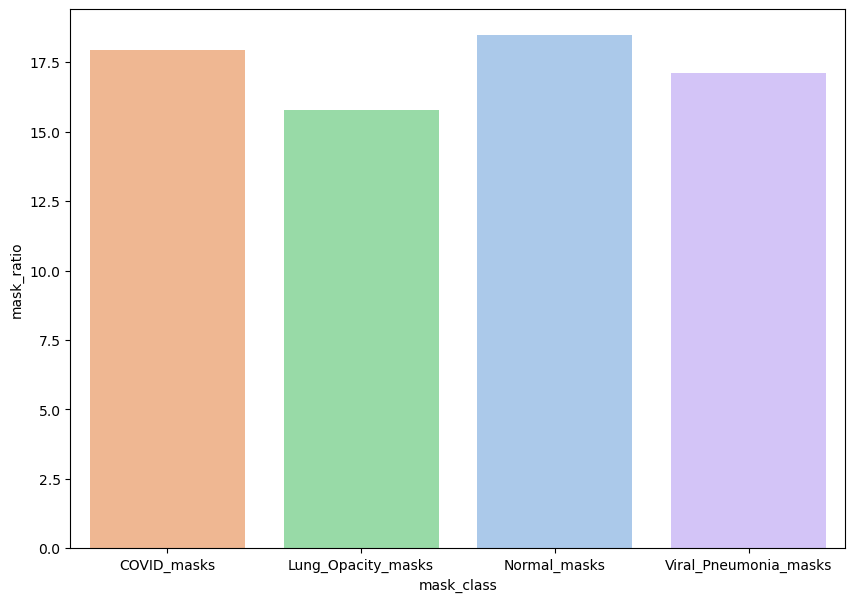

In [18]:
# Show the average usefull surface per class
plt.figure(figsize=(10, 7))

sns.barplot(x='mask_class', y='mask_ratio', palette=['#FFB482', '#8DE5A1', '#A1C9F4', '#D0BBFF'], data=mask_data_grouped);


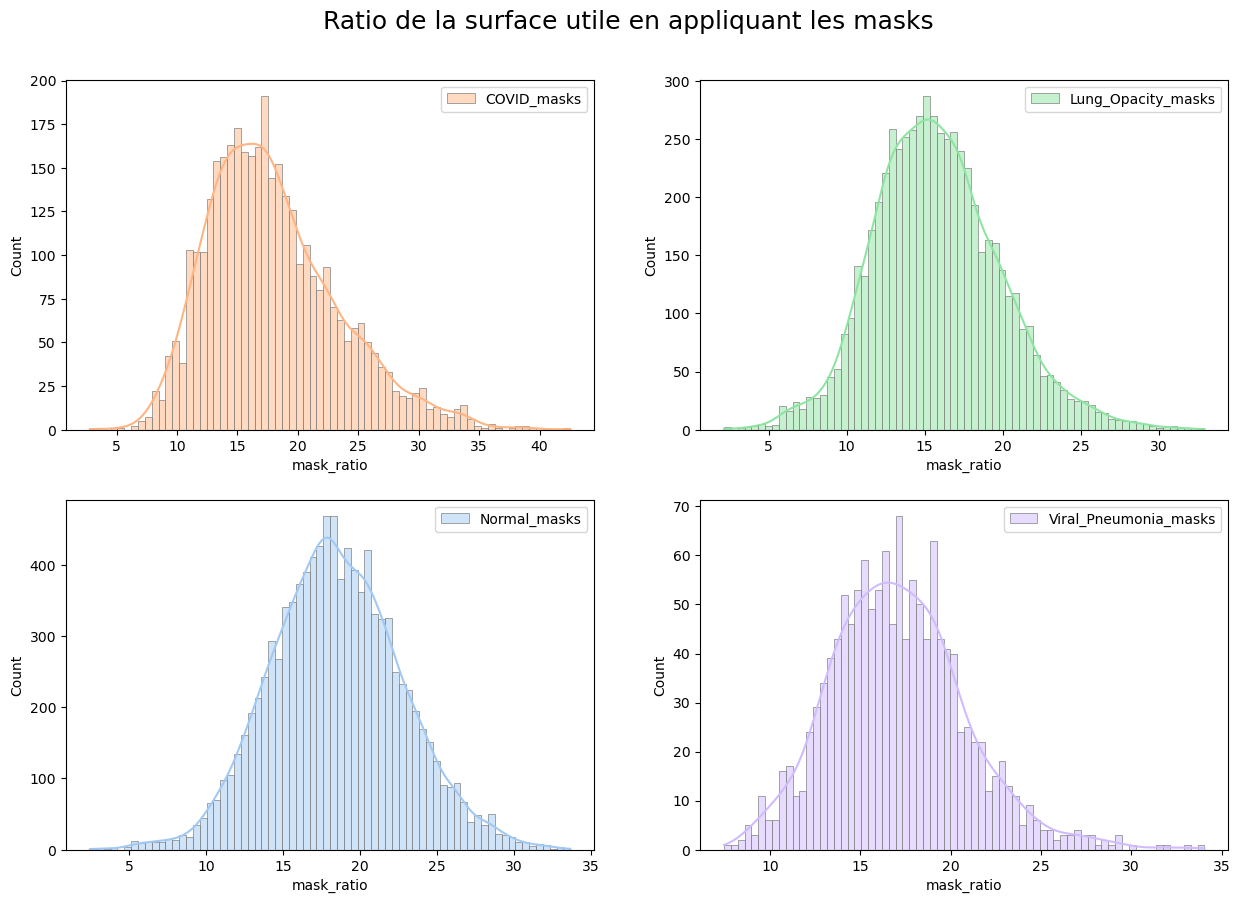

In [20]:
# Ratio distribution per mask class
j = 1

plt.figure(figsize=(15, 10))
plt.suptitle("Taille d'iamges par classe", fontsize=18, y=0.95)

palette = ['#A1C9F4', '#8DE5A1', '#FFB482', '#D0BBFF']

for mask_class in mask_metadata['mask_class'].unique():

    plt.subplot(2, 2, j)
    j = j +1
    sns.histplot(x=mask_metadata[mask_metadata['mask_class']==mask_class]['mask_ratio'], bins=70, hue=mask_metadata['mask_class'],
                 label=mask_class, kde=True, palette=['#FFB482', '#8DE5A1', '#A1C9F4', '#D0BBFF'], edgecolor='gray',
                data=mask_metadata)
    
    plt.legend()
    plt.suptitle("Ratio de la surface utile en appliquant les masks", fontsize=18, y=0.95)
    plt.savefig('ratio_surface_utile.svg')
    plt.savefig('ratio_surface_utile.png')
